In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_otsu

import importlib
import sys

sys.path.append('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil\\notebooks')

import amglib.imageutils as amg
import amglib.readers as rd
import amglib.bb as bb

import os

os.chdir('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil')

import pandas as pd
import datetime 

from scipy.optimize import curve_fit

In [3]:
ts2 = rd.readImages('data/02_rawdata/Sand/2/2_{0:05d}.fits',first=1,last=120).astype(float)
timestamps=rd.read_fits_meta_data2('data/02_rawdata/Sand/2/2_{0:05d}.fits',first=1,last=120, parlist=['FRAME'])

  0%|          | 0/119 [00:00<?, ?it/s]

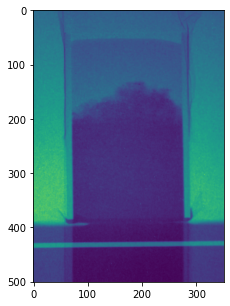

In [4]:
plt.figure(figsize=(7,5))
plt.imshow(ts2[50][::-1]) # added a flip -> originally we looked at ts2[50]
# plt.grid()

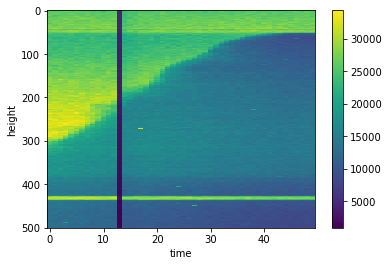

In [5]:
plt.imshow(ts2[30:80,::-1, 150].transpose(),aspect='auto', interpolation='none') # MM COMMENT -> Maybe 44:80??
plt.xlabel('time')
plt.ylabel('height');
plt.colorbar()

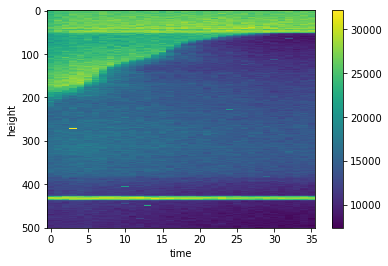

In [7]:
plt.imshow(ts2[44:80,::-1, 150].transpose(),aspect='auto', interpolation='none') # MM COMMENT -> Maybe 44:80??
plt.xlabel('time')
plt.ylabel('height');
plt.colorbar()

###### Remove black part ? 

In [47]:
tslice= ts2[44:80,::-1,150].transpose() # -> 44 to remove big black thinkg

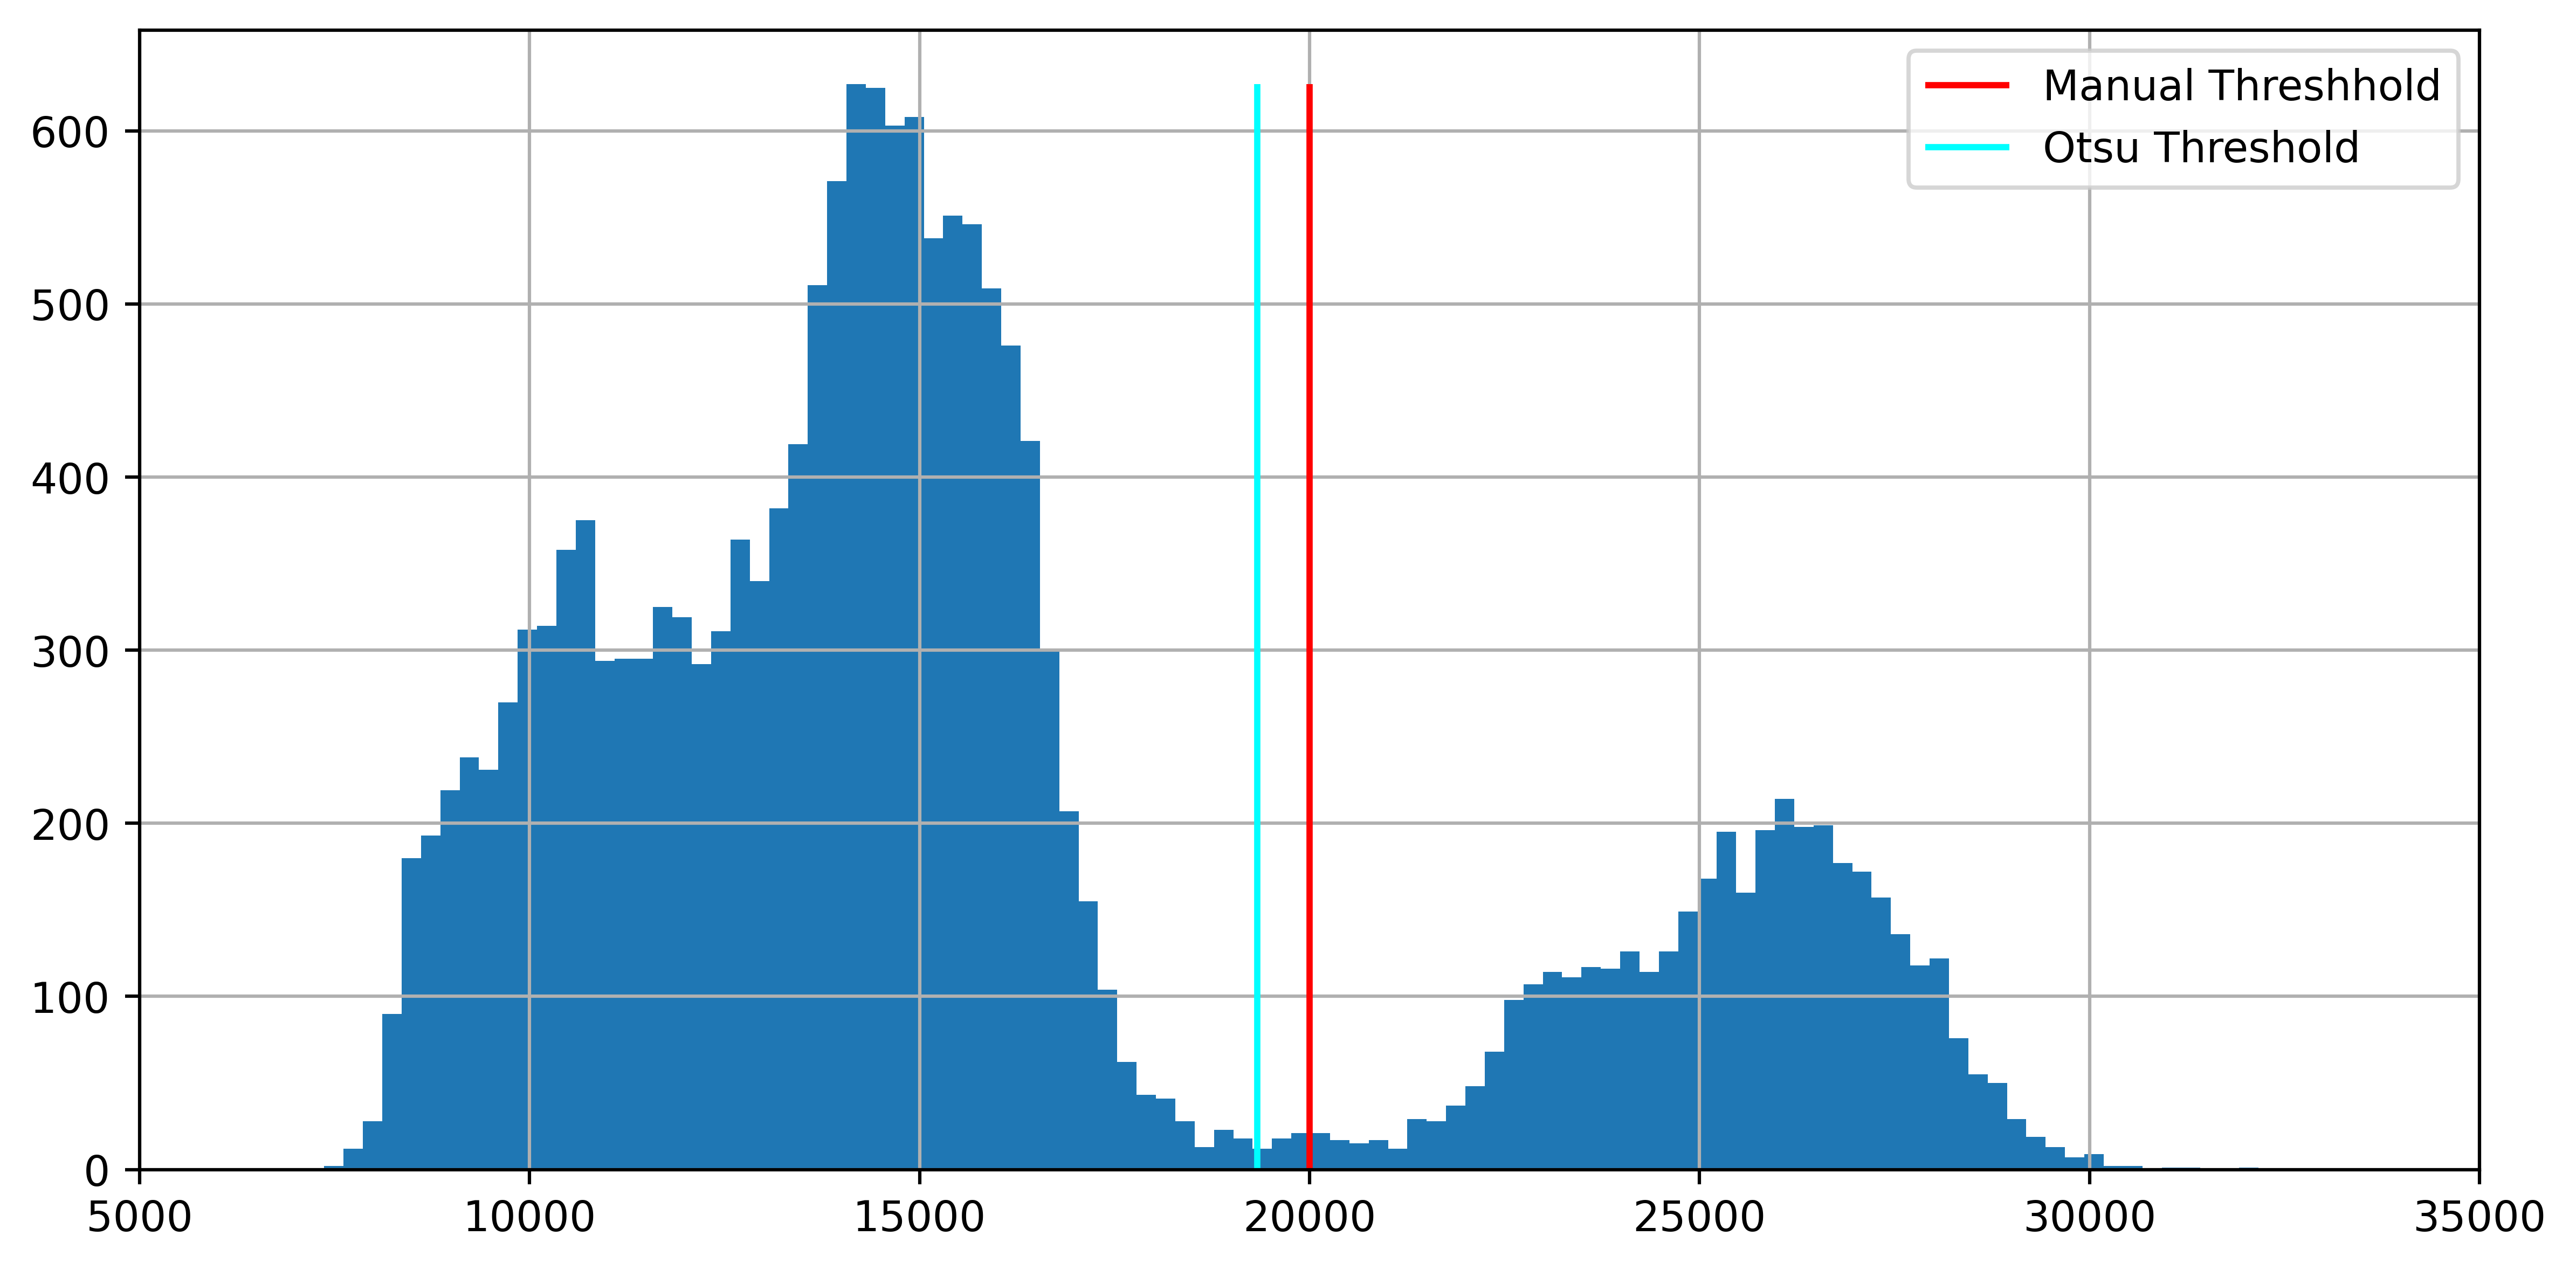

In [48]:
plt.figure(dpi=560, figsize=(10,5))
bin_fills = plt.hist(tslice.ravel(), bins=100)[0]
plt.vlines([20000],ymax=bin_fills.max(),ymin=0,color='red', label = "Manual Threshhold")
plt.vlines([threshold_otsu(tslice)],ymax=bin_fills.max(),ymin=0,color='cyan', label = "Otsu Threshold")
plt.grid()
plt.xlim(5000, 35000)
plt.legend()

In [50]:
threshold_otsu(tslice)

19330.580078125

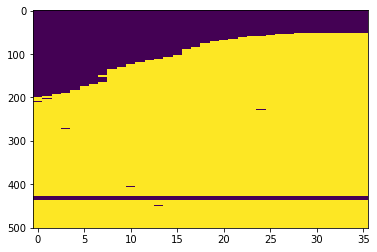

In [51]:
plt.imshow(tslice<20000,aspect='auto',interpolation='none')

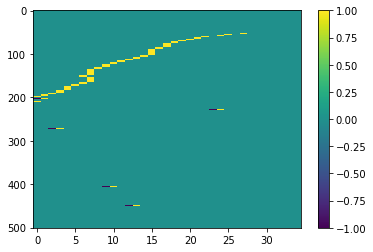

In [52]:
bts=tslice<20000
plt.imshow(bts[:,1:].astype(float)-bts[:,:-1].astype(float),aspect='auto',interpolation='none')
plt.colorbar()

In [54]:
dts=bts[:,1:].astype(float)-bts[:,:-1].astype(float)
points=np.where(0<dts)

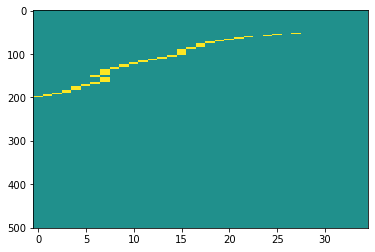

In [64]:
# remove outliers
dts[200:500, :] = 0
plt.imshow(dts, aspect='auto',interpolation='none')

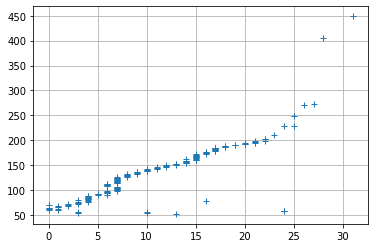

In [127]:
plt.plot(points[1], np.flip((points[0])),'+')
plt.grid()

In [82]:
cutoff = -9

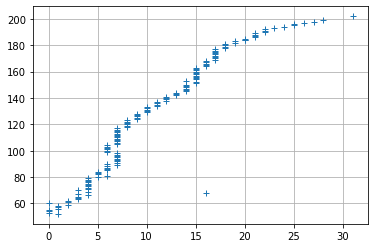

In [83]:
plt.plot(points[1][:cutoff], np.flip(points[0][:cutoff]),'+')
plt.grid()

##### TIME 

In [100]:
timestamps_s = np.zeros((len(timestamps['FRAME']), 2))
for i in range(len(timestamps['FRAME'])):
    s=timestamps['FRAME'][i][-2:]
    m=timestamps['FRAME'][i][-5:-3]
    timestamps_s[i] = (m, s)
time_array = timestamps_s[:,0] * 60 + timestamps_s[:,1];
time_array = pd.to_timedelta(time_array, unit='second');

In [101]:
# time_array[44], time_array[60], time_array[80]
time_array = time_array[44:81] 

In [103]:
time_array

TimedeltaIndex(['0 days 00:08:00', '0 days 00:08:03', '0 days 00:08:05',
                '0 days 00:08:07', '0 days 00:08:10', '0 days 00:08:12',
                '0 days 00:08:14', '0 days 00:08:17', '0 days 00:08:19',
                '0 days 00:08:21', '0 days 00:08:24', '0 days 00:08:26',
                '0 days 00:08:29', '0 days 00:08:31', '0 days 00:08:33',
                '0 days 00:08:36', '0 days 00:08:38', '0 days 00:08:40',
                '0 days 00:08:43', '0 days 00:08:45', '0 days 00:08:47',
                '0 days 00:08:50', '0 days 00:08:52', '0 days 00:08:55',
                '0 days 00:08:57', '0 days 00:08:59', '0 days 00:09:02',
                '0 days 00:09:04', '0 days 00:09:06', '0 days 00:09:09',
                '0 days 00:09:11', '0 days 00:09:13', '0 days 00:09:16',
                '0 days 00:09:18', '0 days 00:09:20', '0 days 00:09:23',
                '0 days 00:09:25'],
               dtype='timedelta64[ns]', freq=None)

In [107]:
# np.unique(points[1][:cutoff])

In [111]:
time_array[np.unique(points[1][:cutoff])] 
time_array[np.unique(points[1][:cutoff])] - time_array[0] # normalized to time 0 being the first image
time_delta_array = time_array[np.unique(points[1][:cutoff])] - time_array[0]

In [112]:
@np.vectorize
def convert_timedelta_to_second_int(val):
    return val.total_seconds()

subs = {k:v for v,k in zip(time_delta_array, np.unique(points[1][:cutoff]))}
new_time_array = np.array([subs.get(item,item) for item in points[1][:cutoff]])
new_time_array = convert_timedelta_to_second_int(new_time_array)

##### PX 

In [113]:
px_per_centimeter = 1578.0713/14 # px / cm
centimeter_per_pixel = px_per_centimeter**(-1)

In [114]:
cm_height = centimeter_per_pixel * np.flip(points[0][:cutoff]) # cm * px^-1 * px = cm

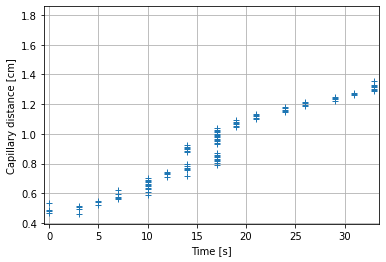

In [117]:
plt.figure()
plt.plot(new_time_array, cm_height, '+')
plt.xlabel("Time [s]")
plt.ylabel("Capillary distance [cm]")
plt.xlim(-0.5,33.5)
plt.grid()

In [121]:
def srqt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b

height = cm_height # cm

time = new_time_array # s

popt, pcov = curve_fit(srqt_analysis, time, height, p0=[2.5, 0.1])

constants_sqrt, displacement = popt
new_model = lambda t: constants_sqrt * np.sqrt(t) + displacement   # cm = sqrt(...) * sqrt(time) -> constant has units m/time
time_linspace = np.linspace(0,35,100)

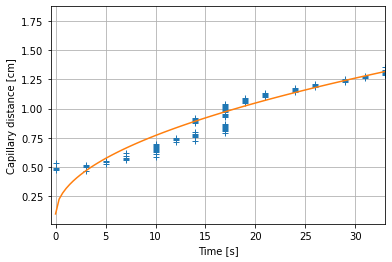

In [123]:
plt.figure()
plt.plot(new_time_array, cm_height, '+')
plt.plot(time_linspace, new_model(time_linspace))
plt.xlabel("Time [s]")
plt.ylabel("Capillary distance [cm]")
plt.xlim(-0.5,33)
plt.grid()

In [126]:
new_time_array

array([73., 66., 64., 62., 59., 59., 57., 55., 52., 52., 52., 50., 50.,
       50., 50., 47., 47., 47., 45., 45., 43., 43., 43., 43., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 38., 38., 38., 38., 38., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 33., 36., 36., 33.,
       33., 33., 33., 33., 33., 31., 31., 31., 29., 29., 29., 29., 26.,
       26., 26., 26., 24., 24., 24., 24., 24., 21., 21., 21., 21., 21.,
       19., 19., 19., 19., 19., 19., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 14., 14., 14., 14., 14., 14., 17.,
       17., 17., 17., 17., 17., 17., 17., 14., 17., 14., 14., 14., 14.,
       12., 12., 12., 14., 12., 10., 10., 10., 10., 10., 10., 10., 10.,
       10.,  7., 10., 38.,  7., 10.,  7.,  7.,  7.,  5.,  5.,  0.,  5.,
        3.,  3.,  3.,  0.,  0.,  0.,  3.])